# TESSplot
## A tool for plotting and interpreting TESS lightcurve data from the SPOC pipeline
### This code allows you to download TESS lightcurves with astroquery, plot the original timeseries data and phase-folded data, compute a Lomb-Scargle periodogram and write the data to a format accepted by the EXOFAST program.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (12,7)

import astroquery
from astroquery.mast import Observations

import pandas as pd
pd.set_option('display.max_colwidth', None)

import astropy
from astropy.io import fits
from astropy.timeseries import LombScargle

from glob import glob
import os
import sys

# Downloading TESS data
#### Let's try it with a reasonable example of a known planet, WASP-18 b:

In [2]:
tic_id = 100100827

### Existing folder check
#### If a folder with the TIC ID number already exists, make a new one.

In [3]:
cwd = os.getcwd()

if os.path.isdir('TIC-{}'.format(tic_id)):
    print("Folder alreay exists.")
else:
    print("Creating folder.")
    os.mkdir('TIC-{}'.format(tic_id))

Folder alreay exists.


### Data download
#### Check the TESS archive for SPOC light curves of the target, pull out the full list of observations and display the needed information only.

In [4]:
obsTable = Observations.query_criteria(
    provenance_name='TESS-SPOC', 
    target_name=tic_id)

data = Observations.get_product_list(obsTable)

data2 = pd.DataFrame(np.array(data))
contain_values = data2[data2['dataURI'].str.contains('lc')]
display(contain_values[['project', 'productFilename', 'description', 'dataproduct_type']])

,project,productFilename,description,dataproduct_type
0,TESS-SPOC,hlsp_tess-spoc_tess_phot_0000000100100827-s0002_tess_v1_lc.fits,FITS,timeseries
2,TESS-SPOC,hlsp_tess-spoc_tess_phot_0000000100100827-s0003_tess_v1_lc.fits,FITS,timeseries
4,TESS-SPOC,hlsp_tess-spoc_tess_phot_0000000100100827-s0029_tess_v1_lc.fits,FITS,timeseries
6,TESS-SPOC,hlsp_tess-spoc_tess_phot_0000000100100827-s0030_tess_v1_lc.fits,FITS,timeseries


#### Download the light curves (without displaying all the information).

In [5]:
%%capture
download_lc = Observations.download_products(data)

#### Find all the actual light curve files with the specified TIC ID in the filename and display them.

In [6]:
files = sorted(glob('mastDownload/HLSP/*{}*/*lc*'.format(tic_id)))
files = pd.DataFrame(np.array(files))
display(files)
files = sorted(glob('mastDownload/HLSP/*{}*/*lc*'.format(tic_id)))

,0
0,mastDownload/HLSP/hlsp_tess-spoc_tess_phot_0000000100100827-s0002_tess_v1_tp/hlsp_tess-spoc_tess_phot_0000000100100827-s0002_tess_v1_lc.fits
1,mastDownload/HLSP/hlsp_tess-spoc_tess_phot_0000000100100827-s0003_tess_v1_tp/hlsp_tess-spoc_tess_phot_0000000100100827-s0003_tess_v1_lc.fits
2,mastDownload/HLSP/hlsp_tess-spoc_tess_phot_0000000100100827-s0029_tess_v1_tp/hlsp_tess-spoc_tess_phot_0000000100100827-s0029_tess_v1_lc.fits
3,mastDownload/HLSP/hlsp_tess-spoc_tess_phot_0000000100100827-s0030_tess_v1_tp/hlsp_tess-spoc_tess_phot_0000000100100827-s0030_tess_v1_lc.fits


#### Arrays always start at eg. files[0] - go through and find the ones you want, and label them by sector number.

In [7]:
fits_file1 = files[0]
fits_file2 = files[1]
fits_file3 = files[2]
fits_file4 = files[3]

sector1 = '02'
sector2 = '03'
sector3 = '29'
sector4 = '30'

# Reading in TESS data
#### TESS-SPOC data comes as a .fits file - you can check the headers in a code or use a program like fv to look at what options there are available. Here we're just pulling out the time, the raw SAP flux, the detrended and cleaned PDCSAP flux, the errors on the PDCSAP flux, and the background flux.

In [8]:
with fits.open(fits_file1, mode="readonly") as hdulist:
    time1 = hdulist[1].data['TIME']
    sap1 = hdulist[1].data['SAP_FLUX']
    flux1 = hdulist[1].data['PDCSAP_FLUX']
    flux_err1 = hdulist[1].data['PDCSAP_FLUX_ERR']
    bkg1 = hdulist[1].data['SAP_BKG']

In [9]:
with fits.open(fits_file2, mode="readonly") as hdulist:
    time2 = hdulist[1].data['TIME']
    sap2 = hdulist[1].data['SAP_FLUX']
    flux2 = hdulist[1].data['PDCSAP_FLUX']
    flux_err2 = hdulist[1].data['PDCSAP_FLUX_ERR']
    bkg2 = hdulist[1].data['SAP_BKG']

In [10]:
with fits.open(fits_file3, mode="readonly") as hdulist:
    time3 = hdulist[1].data['TIME']
    sap3 = hdulist[1].data['SAP_FLUX']
    flux3 = hdulist[1].data['PDCSAP_FLUX']
    flux_err3 = hdulist[1].data['PDCSAP_FLUX_ERR']
    bkg3 = hdulist[1].data['SAP_BKG']

In [11]:
with fits.open(fits_file4, mode="readonly") as hdulist:
    time4 = hdulist[1].data['TIME']
    sap4 = hdulist[1].data['SAP_FLUX']
    flux4 = hdulist[1].data['PDCSAP_FLUX']
    flux_err4 = hdulist[1].data['PDCSAP_FLUX_ERR']
    bkg4 = hdulist[1].data['SAP_BKG']

# Normalising TESS data
#### We often want to normalise our data and remove any NaN values - the PDCSAP fluxes come in e-/s, but normalised is usually easier to read. We take the median of the datapoints (not the mean as this is affected by the transits) and divide by this value.

In [12]:
fluxnanremoved1 = flux1[np.logical_not(np.isnan(flux1))]
norm_factor1 = np.median(fluxnanremoved1)
norm_flux1 = flux1/norm_factor1

flux_errnanremoved1 = flux_err1[np.logical_not(np.isnan(flux_err1))]
norm_factor_err1 = 1
norm_flux_err1 = flux_err1/norm_factor_err1

In [13]:
fluxnanremoved2 = flux2[np.logical_not(np.isnan(flux2))]
norm_factor2 = np.median(fluxnanremoved2)
norm_flux2 = flux2/norm_factor2

flux_errnanremoved2 = flux_err2[np.logical_not(np.isnan(flux_err2))]
norm_factor_err2 = 1
norm_flux_err2 = flux_err2/norm_factor_err2

In [14]:
fluxnanremoved3 = flux3[np.logical_not(np.isnan(flux3))]
norm_factor3 = np.median(fluxnanremoved3)
norm_flux3 = flux3/norm_factor3

flux_errnanremoved3 = flux_err3[np.logical_not(np.isnan(flux_err3))]
norm_factor_err3 = 1
norm_flux_err3 = flux_err3/norm_factor_err3

In [15]:
fluxnanremoved4 = flux4[np.logical_not(np.isnan(flux4))]
norm_factor4 = np.median(fluxnanremoved4)
norm_flux4 = flux4/norm_factor4

flux_errnanremoved4 = flux_err4[np.logical_not(np.isnan(flux_err4))]
norm_factor_err4 = 1
norm_flux_err4 = flux_err4/norm_factor_err4

# Plotting TESS data

In [16]:
facecolor='powderblue'
linecolor='steelblue'

In [17]:
fig = plt.figure()

plt.plot(time1, norm_flux1, marker='.', color='grey', markersize=5.0, linestyle='None',
        label='Sector {}'.format(sector1))
plt.xlabel('Time [TBJD]')
plt.ylabel('PDCSAP flux [e-/s]')

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='lower left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.savefig("TIC-{}/TIC-{}_S{}.pdf".format(tic_id,tic_id,sector1))

<Figure size 864x504 with 0 Axes>

In [18]:
fig = plt.figure()

plt.plot(time2, norm_flux2, marker='.', color='grey', markersize=5.0, linestyle='None',
        label='Sector {}'.format(sector2))
plt.xlabel('Time [TBJD]')
plt.ylabel('PDCSAP flux [e-/s]')

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='lower left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.savefig("TIC-{}/TIC-{}_S{}.pdf".format(tic_id,tic_id,sector2))

<Figure size 864x504 with 0 Axes>

In [19]:
fig = plt.figure()

plt.plot(time3, norm_flux3, marker='.', color='grey', markersize=5.0, linestyle='None',
        label='Sector {}'.format(sector3))
plt.xlabel('Time [TBJD]')
plt.ylabel('PDCSAP flux [e-/s]')

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='lower left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.savefig("TIC-{}/TIC-{}_S{}.pdf".format(tic_id,tic_id,sector3))

<Figure size 864x504 with 0 Axes>

In [20]:
fig = plt.figure()

plt.plot(time4, norm_flux4, marker='.', color='grey', markersize=5.0, linestyle='None',
        label='Sector {}'.format(sector4))
plt.xlabel('Time [TBJD]')
plt.ylabel('PDCSAP flux [e-/s]')

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='lower left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.savefig("TIC-{}/TIC-{}_S{}.pdf".format(tic_id,tic_id,sector4))

<Figure size 864x504 with 0 Axes>

#### Concatenate all the TESS arrays together for plotting the entire dataset.

In [21]:
time = np.concatenate([time1,time2])
time = np.concatenate([time,time3])
time = np.concatenate([time,time4])

In [22]:
norm_flux = np.concatenate([norm_flux1,norm_flux2])
norm_flux = np.concatenate([norm_flux,norm_flux3])
norm_flux = np.concatenate([norm_flux,norm_flux4])

In [23]:
norm_flux_err = np.concatenate([norm_flux_err1,norm_flux_err2])
norm_flux_err = np.concatenate([norm_flux_err,norm_flux_err3])
norm_flux_err = np.concatenate([norm_flux_err,norm_flux_err4])

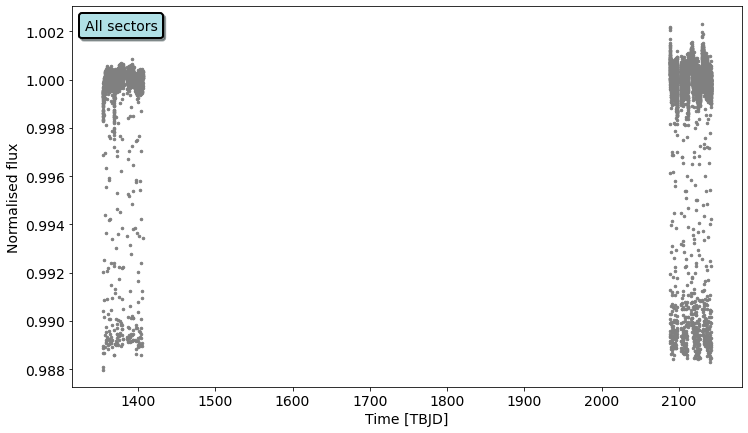

In [24]:
fig = plt.figure()

plt.plot(time, norm_flux, marker='.', color='grey', markersize=5.0, linestyle='None',
         label='All sectors')
plt.xlabel('Time [TBJD]')
plt.ylabel('Normalised flux')

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='upper left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.savefig("TIC-{}/TIC-{}_all.pdf".format(tic_id,tic_id))

# Phase Folding

#### Set up the variables of planetary period and epoch (time of central transit) - you can check these on ExoFOP, or just try and eyeball it.

In [2]:
period1 = 0.9414563
epoch1 = 2458381.76006 - 2457000

period1_2dp = np.float("%.2f" % period1)

#### Don't worry if this returns an error, it still works!

In [3]:
phase1 = (((time - (epoch1 + (0.5 * period1))) % period1) / period1) - 0.5

NameError: name 'time' is not defined

In [4]:
fig = plt.figure()

plt.plot(phase1, norm_flux, marker='.', color='grey', markersize=5.0, linestyle='None',
         label='All sectors\nPhase folded: {} d'.format(period1_2dp))
plt.axvline(0, color=linecolor, linestyle='dashed')
plt.xlabel('Phase')
plt.ylabel('Normalised flux')

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='lower left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.savefig("TIC-{}/TIC-{}_all_phase_{}.pdf".format(tic_id,tic_id,period1_2dp))

NameError: name 'phase1' is not defined

<Figure size 864x504 with 0 Axes>

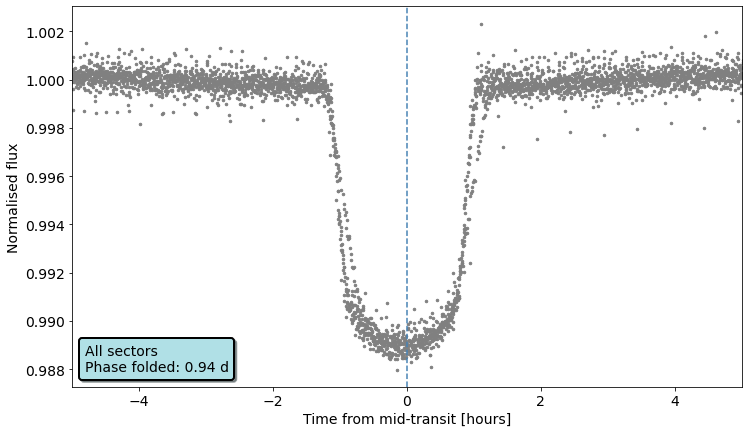

In [28]:
fig = plt.figure()

plt.plot(phase1*period1*24, norm_flux, marker='.', color='grey', markersize=5.0, linestyle='None',
         label='All sectors\nPhase folded: {} d'.format(period1_2dp))
plt.axvline(0, color=linecolor, linestyle='dashed')
plt.xlabel('Time from mid-transit [hours]')
plt.ylabel('Normalised flux')
plt.xlim(-5,5)

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='lower left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.savefig("TIC-{}/TIC-{}_time_cut_{}.pdf".format(tic_id,tic_id,period1_2dp))

# Lomb-Scargle Periodogram
#### You generally want to run LS on un-normalised lightcurves to keep some of the periodicity. You can change this as well to run on the original SAP flux if wanted.

In [29]:
flux_pdc = np.concatenate([flux1,flux2])
flux_pdc = np.concatenate([flux_pdc,flux3])
flux_pdc = np.concatenate([flux_pdc,flux4])

flux_err_pdc = np.concatenate([flux_err1, flux_err2])
flux_err_pdc = np.concatenate([flux_err_pdc, flux_err3])
flux_err_pdc = np.concatenate([flux_err_pdc, flux_err4])

In [30]:
indices = np.logical_not(np.logical_or(np.isnan(time), np.isnan(flux_pdc), np.isnan(flux_err_pdc)))
time_ls = time[indices]
flux_ls = flux_pdc[indices]
fluxerr_ls = flux_err_pdc[indices]

#### Calculate the LS parameters and convert frequency into period for easier visualisation of periodic signals.

In [31]:
frequency, power = LombScargle(time_ls, flux_ls, dy=fluxerr_ls).autopower(
    minimum_frequency=1/2,
    maximum_frequency=1/0.5,
    samples_per_peak=50)
period_estimate = 1/frequency

In [32]:
best_frequency = frequency[np.argmax(power)]
best_period = period_estimate[np.argmax(power)]
best_period_4dp = np.float("%.4f" % best_period)
print("Best period is:", best_period_4dp, "days")

Best period is: 0.9415 days


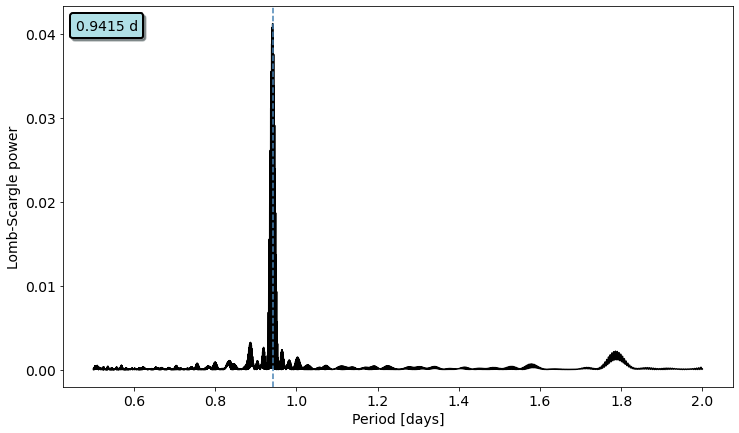

In [33]:
fig = plt.figure()

plt.plot(period_estimate, power, color='black')
plt.axvline(best_period, color=linecolor, linestyle='dashed', 
            label='{} d'.format(best_period_4dp))
plt.xlabel("Period [days]")
plt.ylabel("Lomb-Scargle power")

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='upper left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.savefig("TIC-{}/TIC-{}_LS_{}d.pdf".format(tic_id,tic_id,best_period_4dp))

#### Phase fold the data on this new best periodic signal estimate.

In [34]:
phaserot = (((time - (epoch1 + (0.5 * best_period))) % best_period) / best_period) - 0.5

/home/astro/phrtxb/tess/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in remainder
  """Entry point for launching an IPython kernel.


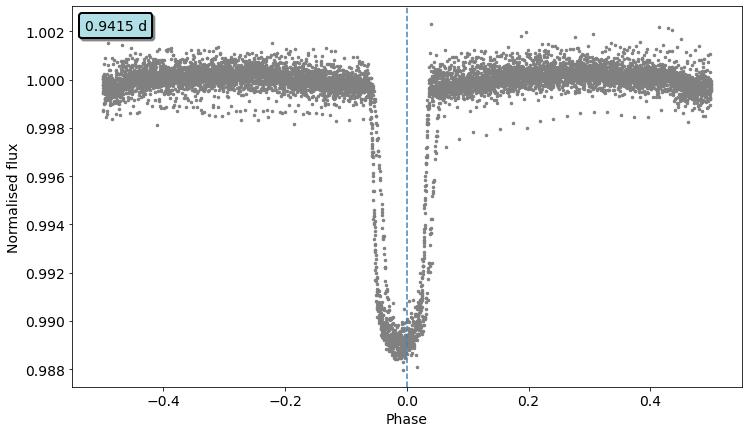

In [35]:
fig = plt.figure()

plt.plot(phaserot, norm_flux, marker='.', color='grey', markersize=5.0, linestyle='None', 
         label="{} d".format(best_period_4dp))
plt.axvline(0, color=linecolor, linestyle='dashed')
plt.xlabel('Phase')
plt.ylabel('Normalised flux')

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='upper left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.savefig("TIC-{}/TIC-{}_phaserot_{}d.pdf".format(tic_id,tic_id,best_period_4dp))

# EXOFAST table creation
#### EXOFAST only takes a maximum of 5000 datapoints, which is more than we have. Let's cut out the transits only and print them back into a format that EXOFAST can interpret.

In [45]:
pcut = 0.185
bjd = np.array(time) + 2457000.0
flux = np.array(norm_flux)
fluxnanremoved = flux[np.logical_not(np.isnan(flux))]
norm_factor = np.median(fluxnanremoved)
norm_flux = flux/norm_factor
flux_error = np.array(norm_flux_err)
fractional_uncertainty = np.divide(flux_error, flux)
bjd_cut = []
flux_cut = []
err_cut = []
norm_flux_cut = []
for i in range(0, len(time)):
    if -pcut <= phase1[i] <= pcut:
        bjd_cut.append(bjd[i])
        flux_cut.append(flux[i])
        err_cut.append(fractional_uncertainty[i])
        norm_flux_cut.append(norm_flux[i])

if len(flux_cut) < 5000:
    print(len(flux_cut))
else:
    print("Number of points exceeds 5000, please reduce the value of pcut.")

3677


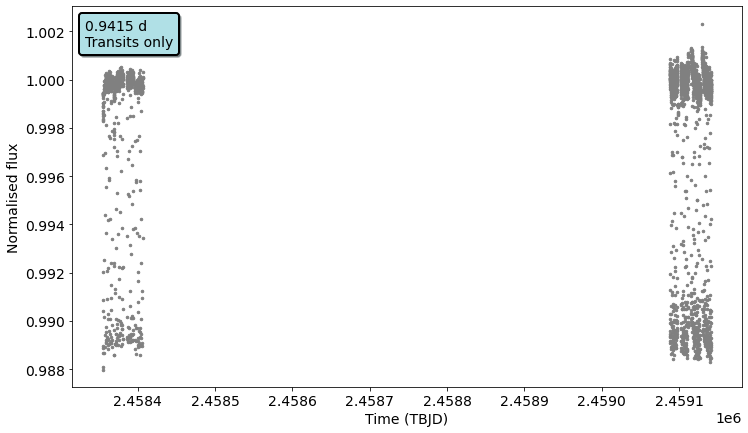

In [37]:
fig,ax = plt.subplots()

ax.plot(bjd_cut, flux_cut, marker='.', color='grey', markersize=5.0, linestyle='None', 
         label="{} d\nTransits only".format(best_period_4dp))
ax.set_ylabel("Normalised flux")
ax.set_xlabel("Time (TBJD)")

leg = plt.legend(handlelength=0, 
                 handletextpad=0, 
                 fancybox=True,
                 shadow=True,
                 loc='upper left')
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor(facecolor)
leg.legendHandles[0]._legmarker.set_markersize(0)

plt.show()

In [38]:
stdout_obj = sys.stdout
sys.stdout = open("TIC-{}/{}_EXOFAST_{}d.txt" .format(tic_id,tic_id,period1_2dp), "w" )
print("|             BJD | Normalised_Flux | Normalised_Flux_Uncertainty | Accepted |\n|          double |          double |                      double |      int |\n|            days |                 |                             |          |")
for i in range(0, len(bjd_cut)):
    print(bjd_cut[i], '\t', flux_cut[i], '\t', err_cut[i], '\t', '1')
sys.stdout.close()
sys.stdout = stdout_obj